<a href="https://colab.research.google.com/github/danyentezari/bn-ocr/blob/main/keras_ocr_realvalues_bignumber_mnist.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Instructions
1. Upload 'kaggle.json.zip'
2. Upload sample image (e.g, '8.jpg')

In [ ]:
!pip install keras==2.2.5
!pip install tensorflow==1.13.1
!unzip kaggle.json.zip
!mkdir ~/.kaggle 
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download scolianni/mnistasjpg
!unzip mnistasjpg.zip
!pip install keras==2.2.5
!pip install tensorflow==1.13.1
!pip install 'h5py==2.10.0' --force-reinstall
!pip install cairocffi
!pip install gdown

In [18]:
import matplotlib.pyplot as plt
from os import listdir
from os.path import isfile, join
import re
import cv2
import string
from PIL import Image
import os
import itertools
import codecs
import re
import datetime
import cairocffi as cairo
import editdistance
import numpy as np
from scipy import ndimage
import pylab
import keras
import tensorflow
from keras import backend as K


from keras.models import Model
from keras.models import Sequential

from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.layers import Input, Activation
from keras.layers import Reshape, Lambda
from keras.layers import Conv2D, Lambda, MaxPooling2D # convolution layers
from keras.layers import Dense, Dropout, Flatten # core layers
from keras.layers.merge import add, concatenate

from keras.layers.recurrent import GRU
from keras.optimizers import SGD
from keras.utils.data_utils import get_file
from keras.preprocessing import image
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
import keras.callbacks
#from keras.metrics import Metric
from tensorflow.python.keras.metrics import Metric
from tensorflow.keras import datasets, layers, models
from keras.utils.np_utils import to_categorical
from keras.preprocessing.image import ImageDataGenerator

from sklearn.model_selection import train_test_split

from keras.layers.normalization import BatchNormalization

In [6]:
alphabet = '0123456789'

In [5]:
def loadImage(filepath):
  img = load_img(filepath)
  img = img_to_array(img)
  # img = img.reshape(1, 448, 64, 3)
  # img = img.reshape(64, 192, 3)
  img = img.astype('float32')
  img = img / 255.0
  return img

In [7]:
from os import listdir
from os.path import isfile, join

ch = 28
cw = 28

data_F = np.empty((0, ch, cw, 3))
data_L = np.empty((0))

i = 0
for f_label in listdir('./trainingSet/trainingSet'):
  for img_name in listdir(f'./trainingSet/trainingSet/{f_label}'):
    img = loadImage(f'./trainingSet/trainingSet/{f_label}/{img_name}')

    data_F = np.append(data_F, [img], axis=0)
    data_L = np.append(data_L, [f_label], axis=0)

In [8]:
data_L_dist = to_categorical(data_L)

In [9]:
sample_image = loadImage('./trainingSet/trainingSet/0/img_1.jpg')
Image.fromarray(np.uint8(sample_image*255)).convert('RGB')

### Features and Labels

In [10]:
print(data_F.shape)
print(data_L.shape)
print(data_L_dist.shape)

(42000, 28, 28, 3)
(42000,)
(42000, 10)


### Alternative Model

In [11]:
train_F, test_F, train_L_dist, test_L_dist = train_test_split(data_F, data_L_dist, test_size=0.1, random_state=0)

In [12]:
train_F.shape, test_F.shape, train_L_dist.shape, test_L_dist.shape

((37800, 28, 28, 3), (4200, 28, 28, 3), (37800, 10), (4200, 10))

In [13]:
# With data augmentation to prevent overfitting

datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=15,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.01, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=False,  # randomly flip images
        vertical_flip=False)  # randomly flip images


#datagen.fit(X_train)
train_gen = datagen.flow(train_F, train_L_dist, batch_size=128)
test_gen = datagen.flow(test_F, test_L_dist, batch_size=128)

In [14]:
epochs = 5
batch_size = 128
train_steps = train_F.shape[0] // batch_size
valid_steps = train_L_dist.shape[0] // batch_size

es = keras.callbacks.EarlyStopping(
        monitor="val_acc", # metrics to monitor
        patience=10, # how many epochs before stop
        verbose=1,
        mode="max", # we need the maximum accuracy.
        restore_best_weights=True, # 
     )

rp = keras.callbacks.ReduceLROnPlateau(
        monitor="val_acc",
        factor=0.2,
        patience=3,
        verbose=1,
        mode="max",
        min_lr=0.00001,
     )

In [19]:
model1=Sequential()

#model1.add(Lambda(standardize,input_shape=(28,28,1)))    
model1.add(Conv2D(filters=64, kernel_size = (3,3), activation="relu", input_shape=(28,28,3)))
model1.add(Conv2D(filters=64, kernel_size = (3,3), activation="relu"))
model1.add(MaxPooling2D(pool_size=(2,2)))
model1.add(BatchNormalization())

model1.add(Conv2D(filters=128, kernel_size = (3,3), activation="relu"))
model1.add(Conv2D(filters=128, kernel_size = (3,3), activation="relu"))
model1.add(MaxPooling2D(pool_size=(2,2)))
model1.add(BatchNormalization())    

model1.add(Conv2D(filters=256, kernel_size = (3,3), activation="relu"))
model1.add(MaxPooling2D(pool_size=(2,2)))
model1.add(BatchNormalization())
    
model1.add(Flatten())
model1.add(Dense(512,activation="relu"))
    
model1.add(Dense(10,activation="softmax"))
    
model1.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

Instructions for updating:
Colocations handled automatically by placer.


In [20]:
# metrics1 = model1.fit(x=train_F, y=train_L_dist, epochs=20, verbose=1)

# Fit the model
metrics1 = model1.fit_generator(train_gen, 
                              epochs = epochs, 
                              steps_per_epoch = train_steps,
                              validation_data = test_gen,
                              validation_steps = valid_steps, 
                              callbacks=[es, rp])

Instructions for updating:
Use tf.cast instead.


Epoch 1/5
295/295 [==============================] - 598s 2s/step - loss: 0.1599 - acc: 0.9502 - val_loss: 0.0950 - val_acc: 0.9727
Epoch 2/5
295/295 [==============================] - 517s 2s/step - loss: 0.0626 - acc: 0.9803 - val_loss: 0.0695 - val_acc: 0.9802
Epoch 3/5
295/295 [==============================] - 524s 2s/step - loss: 0.0492 - acc: 0.9844 - val_loss: 0.0793 - val_acc: 0.9779
Epoch 4/5
295/295 [==============================] - 540s 2s/step - loss: 0.0414 - acc: 0.9874 - val_loss: 0.0715 - val_acc: 0.9812
Epoch 5/5
295/295 [==============================] - 530s 2s/step - loss: 0.0404 - acc: 0.9871 - val_loss: 0.0685 - val_acc: 0.9797


In [ ]:
model1.save_weights( './weights2-mnist.h5' )

### Predict

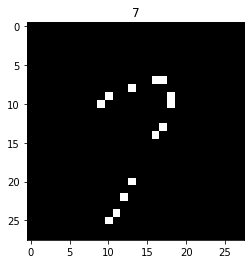

In [21]:
import matplotlib.pyplot as plt
%matplotlib inline
img = data_F[7300]
img = img.astype(np.uint8) 
plt.title(data_L[7300])
plt.imshow(img * 255)

In [22]:
yhat = model1.predict(data_F[7300].reshape(1, ch, cw, 3))
# np.argmax(yhat, axis=1).tolist()
yhat.argmax()

7

8

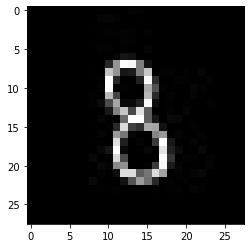

In [24]:
# View sample image and predicted label together

sample_image = loadImage('./8.jpg')
sample_image = 255 - (sample_image * 255)
# Image.fromarray(np.uint8(sample_image*255)).convert('RGB')
img = sample_image.astype(np.uint8) 
plt.imshow(img)

yhat = model1.predict(img.reshape(1, ch, cw, 3))
yhat.argmax()